In [236]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# LIMPIEZA

In [237]:
data = pd.read_csv('./INPUT/diamonds_train.csv')
data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.78,Premium,F,VS1,61.5,58.0,5.93,5.98,3.66,3446
1,1,0.31,Ideal,D,SI1,60.8,56.0,4.37,4.32,2.64,732
2,2,0.30,Ideal,F,SI1,62.3,54.0,4.30,4.34,2.69,475
3,3,1.04,Ideal,E,VVS2,62.0,58.0,6.54,6.46,4.03,9552
4,4,0.65,Ideal,J,SI1,61.4,55.0,5.58,5.62,3.44,1276


In [238]:
# Nos quitamos el id
data = data.iloc[:,1:]
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.78,Premium,F,VS1,61.5,58.0,5.93,5.98,3.66,3446
1,0.31,Ideal,D,SI1,60.8,56.0,4.37,4.32,2.64,732
2,0.30,Ideal,F,SI1,62.3,54.0,4.30,4.34,2.69,475
3,1.04,Ideal,E,VVS2,62.0,58.0,6.54,6.46,4.03,9552
4,0.65,Ideal,J,SI1,61.4,55.0,5.58,5.62,3.44,1276


In [239]:
''' Vemos que en las columnas de medidas (x,y,z) los valores mínimos son 0, por tanto, son valores nulos que nos
desvirtúan las métricas.'''
'''Además, en la medida y el valor máximo es 58.9, que comparado con la media parece traterse de un error'''
data.describe()

,carat,depth,table,x,y,z,price
count,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000
mean,0.797699,61.749721,57.449421,5.730824,5.734808,3.537958,3931.902243
std,0.474309,1.427728,2.234087,1.121767,1.151536,0.695039,3994.318832
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,952.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2397.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000,5317.000000
max,5.010000,79.000000,95.000000,10.740000,58.900000,8.060000,18823.000000


In [240]:
# Teniendo en cuenta lo anterior, quitamos los valores nulos
data = data.loc[(data['x'] != 0) & (data['y'] != 0) & (data['z'] != 0)]
data = data.loc[(data['y'] < 15)]

In [241]:
# Sacamos lista ordenada del tipo de corte del peor al mejor
cut_list = list(data.cut.value_counts().keys())
cut_list.reverse()
# Aplicamos el valor numérico para que lo valore en función de la importancia del corte
data['cut'] = data['cut'].apply(lambda x: cut_list.index(x))

In [242]:
# Sacamos lista ordenada del color del peor al mejor
color_list = sorted(list(data.color.value_counts().keys()),reverse=True)
# Aplicamos el valor numérico para que lo valore en función de la importancia del color
data['color'] = data['color'].apply(lambda x: color_list.index(x))

In [243]:
# Sacamos lista ordenada de la claridad de peor a mejor
clarity_list = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
# Aplicamos el valor numérico para que lo valore en función de la importancia de la claridad
data['clarity'] = data['clarity'].apply(lambda x: clarity_list.index(x))

In [244]:
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.78,3,4,4,61.5,58.0,5.93,5.98,3.66,3446
1,0.31,4,6,2,60.8,56.0,4.37,4.32,2.64,732
2,0.30,4,4,2,62.3,54.0,4.30,4.34,2.69,475
3,1.04,4,5,5,62.0,58.0,6.54,6.46,4.03,9552
4,0.65,4,0,2,61.4,55.0,5.58,5.62,3.44,1276


In [255]:
# Paso a numpy para hacer cálculos
data_arr = data.to_numpy()
data_arr2 = data.to_numpy()

In [248]:
data_arr.shape

(40329, 10)

In [252]:
# Aquí intentaba normalizar los datos
def __normalize(data):
    # Mantener el shape original
    shape = data.shape
    # Reducir a 1 dimensión
    data = np.reshape(data, (-1, ))
    # Encontrar máximo y mínimo
    maximum = np.max(data)
    minimum = np.min(data)
    normalized_values = list()
    # Normalización
    for x in data:
        x_normalized = (x-minimum)/(maximum-minimum)
        normalized_values.append(x_normalized)
    n_array = np.array(normalized_values)
    # Volver al shape original
    return np.reshape(n_array, shape)

In [253]:
__normalize(data_arr)

array([[4.14386655e-05, 1.59379483e-04, 2.12505977e-04, ...,
        3.17696435e-04, 1.94442969e-04, 1.83073899e-01],
       [1.64692132e-05, 2.12505977e-04, 3.18758965e-04, ...,
        2.29506455e-04, 1.40253945e-04, 3.88885937e-02],
       [1.59379483e-05, 2.12505977e-04, 2.12505977e-04, ...,
        2.30568985e-04, 1.42910269e-04, 2.52350847e-02],
       ...,
       [2.12505977e-05, 1.59379483e-04, 1.59379483e-04, ...,
        2.51819582e-04, 1.54066833e-04, 5.96610530e-02],
       [5.63140838e-05, 2.12505977e-04, 5.31264942e-05, ...,
        3.48509802e-04, 2.14099772e-04, 3.00217819e-01],
       [5.36577591e-05, 1.06252988e-04, 1.06252988e-04, ...,
        3.34165648e-04, 2.13037242e-04, 2.10327790e-01]])

In [265]:
# Aquí hacía la prueba con el Normalizer de sklearn
from sklearn.preprocessing import Normalizer

a = Normalizer().fit(data_arr2)
b = a.transform(data_arr2)
pd.DataFrame(b)

,0,1,2,3,4,5,6,7,8,9
0,0.000226,0.000870,0.001160,0.001160,0.017841,0.016826,0.001720,0.001735,0.001062,0.999694
1,0.000421,0.005429,0.008144,0.002715,0.082528,0.076013,0.005932,0.005864,0.003583,0.993592
2,0.000622,0.008296,0.008296,0.004148,0.129203,0.111990,0.008918,0.009001,0.005579,0.985098
3,0.000109,0.000419,0.000523,0.000523,0.006491,0.006072,0.000685,0.000676,0.000422,0.999960
4,0.000508,0.003128,0.000000,0.001564,0.048018,0.043013,0.004364,0.004395,0.002690,0.997891
...,...,...,...,...,...,...,...,...,...,...
40324,0.000291,0.002328,0.002910,0.002328,0.036029,0.032595,0.002963,0.002980,0.001839,0.998799
40325,0.000420,0.005092,0.007638,0.003819,0.078675,0.071291,0.005601,0.005652,0.003475,0.994260
40326,0.000355,0.002664,0.002664,0.005328,0.054607,0.051499,0.004164,0.004209,0.002575,0.997137
40327,0.000188,0.000708,0.000177,0.000708,0.010829,0.010086,0.001166,0.001161,0.000713,0.999888


In [224]:
# Vemos que la correlación más fuerte que tiene el precio es con los quilates
data.corr()

,carat,cut,color,clarity,depth,table,x,y,z,price
carat,1.000000,-0.132682,-0.291301,-0.352029,0.023301,0.181782,0.977937,0.977088,0.976466,0.922324
cut,-0.132682,1.000000,0.018839,0.187315,-0.213116,-0.431824,-0.124958,-0.124542,-0.150496,-0.053028
color,-0.291301,0.018839,1.000000,-0.031485,-0.044324,-0.026522,-0.271204,-0.270910,-0.275009,-0.173780
clarity,-0.352029,0.187315,-0.031485,1.000000,-0.063883,-0.159905,-0.372053,-0.366932,-0.375473,-0.148939
depth,0.023301,-0.213116,-0.044324,-0.063883,1.000000,-0.299474,-0.028792,-0.031800,0.092602,-0.013254
table,0.181782,-0.431824,-0.026522,-0.159905,-0.299474,1.000000,0.196468,0.190443,0.156245,0.126738
x,0.977937,-0.124958,-0.271204,-0.372053,-0.028792,0.196468,1.000000,0.998781,0.991142,0.887715
y,0.977088,-0.124542,-0.270910,-0.366932,-0.031800,0.190443,0.998781,1.000000,0.990813,0.889288
z,0.976466,-0.150496,-0.275009,-0.375473,0.092602,0.156245,0.991142,0.990813,1.000000,0.882774
price,0.922324,-0.053028,-0.173780,-0.148939,-0.013254,0.126738,0.887715,0.889288,0.882774,1.000000


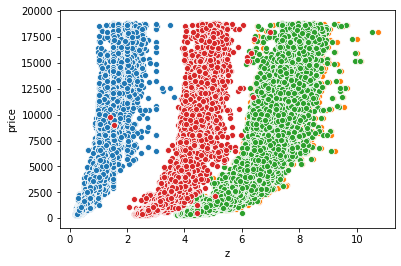

In [225]:
sns.scatterplot(x="carat", y="price", data=data)
sns.scatterplot(x="x", y="price", data=data)
sns.scatterplot(x="y", y="price", data=data)
sns.scatterplot(x="z", y="price", data=data);

In [226]:
data.describe()

,carat,cut,color,clarity,depth,table,x,y,z,price
count,40329.000000,40329.000000,40329.000000,40329.000000,40329.000000,40329.000000,40329.000000,40329.000000,40329.000000,40329.000000
mean,0.797443,2.906023,3.406680,3.056361,61.749991,57.449104,5.730928,5.732842,3.539035,3930.218379
std,0.474074,1.115367,1.700898,1.650886,1.427337,2.233558,1.120068,1.111890,0.691632,3992.486970
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,3.730000,3.710000,1.410000,326.000000
25%,0.400000,2.000000,2.000000,2.000000,61.000000,56.000000,4.710000,4.720000,2.910000,951.000000
50%,0.700000,3.000000,3.000000,3.000000,61.800000,57.000000,5.690000,5.710000,3.520000,2396.000000
75%,1.040000,4.000000,5.000000,4.000000,62.500000,59.000000,6.540000,6.540000,4.030000,5315.000000
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,10.740000,10.540000,6.980000,18823.000000


In [227]:
# Vamos a dividir el dataset por el percentil 50 de los quilates
data_lower = data[data['carat'] <= data.describe()['carat'][5]]
data_greater = data[data['carat'] > data.describe()['carat'][5]]

In [228]:
print(data_lower.shape)
print(data_greater.shape)

(20350, 10)
(19979, 10)


In [229]:
# Asignamos las features a la X
X_lower = data_lower.drop(columns='price')
X_greater = data_greater.drop(columns='price')
# Asignamos el precio a predecir a la y
y_lower = data_lower['price']
y_greater = data_greater['price']

In [230]:
print(X_lower.shape)
print(X_greater.shape)
print(y_lower.shape)
print(y_greater.shape)

(20350, 9)
(19979, 9)
(20350,)
(19979,)


# ENTRENAMIENTO MODELOS

In [189]:
# Dividimos los datos en entrenamiento y test
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_lower, y_lower, test_size=0.2, random_state=42)
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_greater, y_greater, test_size=0.2, random_state=42)

In [191]:
# Entrenamos según modelo

models = {
    'LinearReg': LinearRegression(),
    'LinearSVR': LinearSVR(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=250),
    'XGBRegressor': xgb.XGBRegressor(n_estimators=250),
    'HistGrad': HistGradientBoostingRegressor(),
    'ElasticNet': ElasticNet(random_state=0)
    }

# PRIMERA PARTE DATASET MENOR QUE EL PERCENTIL 50 QUILATES

results_lower = {}

for name,model in models.items():
    
    data_trained = model.fit(X_train_l, y_train_l)
    prediction = data_trained.predict(X_test_l)
    desviation = 1-np.abs(y_test_l-prediction).sum()/len(y_test_l)
    rmse = sqrt(mean_squared_error(y_test_l, prediction))
    
    results_lower[name] = desviation, rmse

    
# SEGUNDA PARTE DATASET MAYOR QUE EL PERCENTIL 50 QUILATES

results_greater = {}

for name,model in models.items():
    
    data_trained = model.fit(X_train_g, y_train_g)
    prediction = data_trained.predict(X_test_g)
    desviation = 1-np.abs(y_test_g-prediction).sum()/len(y_test_g)
    rmse = sqrt(mean_squared_error(y_test_g, prediction))
    
    results_greater[name] = desviation, rmse

In [192]:
results_lower

{'ElasticNet': (-296.3858100607577, 413.32224161165954),
 'HistGrad': (-71.88392367719361, 121.48392577289194),
 'LinearReg': (-155.409291844879, 231.08156450750988),
 'LinearSVR': (-189.17351562516563, 291.71509987430466),
 'RandomForestRegressor': (-70.48614519890984, 124.63721347405985),
 'XGBRegressor': (-69.54509048255765, 122.2768660453245)}

In [193]:
results_greater

{'ElasticNet': (-1322.441702705598, 1847.2443500872114),
 'HistGrad': (-483.0284362855218, 761.4561060921283),
 'LinearReg': (-944.4750795867127, 1406.1888144044424),
 'LinearSVR': (-1083.9803169518193, 1611.8145045385083),
 'RandomForestRegressor': (-489.95758049398603, 797.9123337894864),
 'XGBRegressor': (-493.9299742399871, 794.6782822724795)}

In [ ]:
# Lo descarté por no obtener buenos resultados